In [5]:
from IPython.display import Image

# Altitude and pressure

Recently I was delivering a mini-lesson for Yr7 students on: why does water boil at a lower temperature at a higher altitude? A good answer to this can be found all over the internet and particularly on youtube [here](https://www.youtube.com/watch?v=8lyqFkFsH28&). One concept I wanted to explain was why air pressure is lower at higher altitudes. 

The air pressure around us is due to the weight of the atmosphere above us. At a higher altitude, there is a smaller weight of air above you, so you feel less pressure. This understanding also is the reason for the pressure in water increases as we go deeper (there is a greater weight of water above us) and can be very large (water weighs a lot!).

On a microscopic level, the air pressure comes from the gas particles colliding into things. For a balloon, air particles hitting the inside of a balloon give a force pushing out: this balances the inward forces of the air particles hitting the outside surface and tension of the balloon itself and keeps the balloon inflated. We call a force acting on an area: "pressure". 


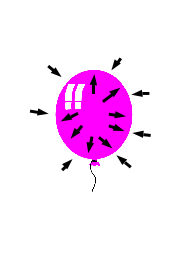

In [7]:
Image(filename='balloon_drawing.png') 
## The arrows show the forces due to pressure from air molecules hitting the balloon surface.
## Not shown is the force due to the tension of the rubber. 

Borrowing on some code from [here](http://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/) (and correcting the gravity mistake in the original code), I adapted this to make nice animations of a vertical slice of atmosphere.

The physics put into this simulation are:
* the balls collide elastically with one another (don't lose any kinetic energy when colliding which is true for an ideal gas.
* the particles all have a weight that causes them to fall.
* the particles collide elastically with the ground (this is another physically sensible approximation).
* the particles collide elastically with the wall/ceiling. Although our atmosphere doesn't have these limits, they don't change the results of the calculation and this also makes the calculation much simpler. 

The code and results are below

In [1]:
"""
Animation of Elastic collisions with Gravity

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!

Adapted by JLim March 2015
"""

import numpy as np
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

class ParticleBox:
    """Orbits class
    
    init_state is an [N x 4] array, where N is the number of particles:
       [[x1, y1, vx1, vy1],
        [x2, y2, vx2, vy2],
        ...               ]

    bounds is the size of the box: [xmin, xmax, ymin, ymax]
    """
    def __init__(self,
                 init_state = [[1, 0, 0, -1],
                               [-0.5, 0.5, 0.5, 0.5],
                               [-0.5, -0.5, -0.5, 0.5]],
                 bounds = [-2, 2, -2, 2],
                 size = 0.04,
                 M = 0.05,
                 G = 9.8):
        self.init_state = np.asarray(init_state, dtype=float)
        self.M = M * np.ones(self.init_state.shape[0])
        self.size = size
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds
        self.G = G

    def step(self, dt):
        """step once by dt seconds"""
        self.time_elapsed += dt
        
       # update positions
        self.state[:, :2] += dt * self.state[:, 2:]
        
        # check for crossing boundary
        while True:
            crossed_x1 = (self.state[:, 0] < self.bounds[0] + self.size)
            crossed_x2 = (self.state[:, 0] > self.bounds[1] - self.size)
            crossed_x1or2 = crossed_x1 | crossed_x2
            if not np.any(crossed_x1or2): break
            self.state[crossed_x1, 0] = 2*(self.bounds[0] + self.size) - self.state[crossed_x1, 0]
            self.state[crossed_x2, 0] = 2*(self.bounds[1] - self.size) - self.state[crossed_x2, 0]
            self.state[crossed_x1or2, 2] *= -1
        
        while True:
            crossed_y1 = (self.state[:, 1] < self.bounds[2] + self.size)
            crossed_y2 = (self.state[:, 1] > self.bounds[3] - self.size)
            crossed_y1or2 = crossed_y1 | crossed_y2
            if not np.any(crossed_y1or2): break
            self.state[crossed_y1, 1] = 2*(self.bounds[2] + self.size) - self.state[crossed_y1, 1]
            self.state[crossed_y2, 1] = 2*(self.bounds[3] - self.size) - self.state[crossed_y2, 1]
            self.state[crossed_y1or2, 3] *= -1


        # find pairs of particles undergoing a collision
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 2 * self.size)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        # update velocities of colliding pairs
        for i1, i2 in zip(ind1, ind2):
            # mass
            m1 = self.M[i1]
            m2 = self.M[i2]

            # location vector
            r1 = self.state[i1, :2]
            r2 = self.state[i2, :2]

            # velocity vector
            v1 = self.state[i1, 2:]
            v2 = self.state[i2, 2:]

            # relative location & velocity vectors
            r_rel = r1 - r2
            v_rel = v1 - v2

            # momentum vector of the center of mass
            v_cm = (m1 * v1 + m2 * v2) / (m1 + m2)

            # collisions of spheres reflect v_rel over r_rel
            rr_rel = np.dot(r_rel, r_rel)
            vr_rel = np.dot(v_rel, r_rel)
            v_rel = 2 * r_rel * vr_rel / rr_rel - v_rel

            # assign new velocities
            self.state[i1, 2:] = v_cm + v_rel * m2 / (m1 + m2)
            self.state[i2, 2:] = v_cm - v_rel * m1 / (m1 + m2) 

        # check for crossing boundary
        crossed_x1 = (self.state[:, 0] < self.bounds[0] + self.size)
        crossed_x2 = (self.state[:, 0] > self.bounds[1] - self.size)
        crossed_y1 = (self.state[:, 1] < self.bounds[2] + self.size)
        crossed_y2 = (self.state[:, 1] > self.bounds[3] - self.size)

        self.state[crossed_x1, 0] = self.bounds[0] + self.size
        self.state[crossed_x2, 0] = self.bounds[1] - self.size

        self.state[crossed_y1, 1] = self.bounds[2] + self.size
        self.state[crossed_y2, 1] = self.bounds[3] - self.size

        self.state[crossed_x1 | crossed_x2, 2] *= -1
        self.state[crossed_y1 | crossed_y2, 3] *= -1

        # add gravity
        self.state[:, 3] -= self.G * dt

In [2]:
#------------------------------------------------------------
# set up initial state
xmin=0
xmax=4
ymin=0
ymax=10

Natoms=200
atom_size=0.1
disp_atom_size=8
speed=3.9

dt = 1. / 30 # 30fps
dt = 8E-3

np.random.seed(0)
init_state =  np.random.random((Natoms, 4))
init_state[:, 0] = init_state[:, 0] * (xmax-xmin)
init_state[:, 1] = init_state[:, 1] * (ymax-ymin)
init_state[:, :2] *= speed

box = ParticleBox(init_state, size=atom_size,bounds = [xmin, xmax, ymin, ymax])

pre_calc=400
## initialise particles before animation
for n in range(pre_calc):
    box.step(dt)


Now we have set up our simulation, we just need to animate it and display it.

In [3]:
#------------------------------------------------------------
# set up figure and animation
fig = plt.figure(figsize=(3,4), dpi=100)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig_padding=0.4  ## this is a fraction of the size
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=( -fig_padding+box.bounds[0], fig_padding+box.bounds[1]), ylim=(-fig_padding+box.bounds[2], fig_padding+box.bounds[3]))

# particles holds the locations of the particles
particles, = ax.plot([], [], 'bo', ms=disp_atom_size)


## plot some more boxes to help dicsussion of pressure vs altitude
box1y=0.9
box2y=3.9
box3y=7.4

ybox_h=0.2
xbox_w=box.bounds[1] - box.bounds[0]


# rect is the box edge
rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)


alt_box1 = plt.Rectangle([0,box1y],xbox_w,ybox_h, ec='green', lw=0, fc='green',alpha=0.5)
alt_box2 = plt.Rectangle([0,box2y],xbox_w,ybox_h, ec='purple', lw=0, fc='purple',alpha=0.5)
alt_box3 = plt.Rectangle([0,box3y],xbox_w,ybox_h, ec='red', lw=0, fc='red',alpha=0.5)
                     
ax.add_patch(alt_box1)
ax.add_patch(alt_box2)
ax.add_patch(alt_box3)

def init():
    """initialize animation"""
    global box, rect
    particles.set_data([], [])
    rect.set_edgecolor('none')
    return particles, rect

def animate(i):
    """perform animation step"""
    global box, rect, dt, ax, fig
    box.step(dt)

#    ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
#             / np.diff(ax.get_xbound())[0])
#    particles.set_markersize(ms)
    # update pieces of the animation
    rect.set_edgecolor('k')
    particles.set_data(box.state[:, 0], box.state[:, 1])

    return particles, rect

In [25]:
ani = animation.FuncAnimation(fig, animate, frames=120,interval=20, blit=True, init_func=init)

# mywriter = animation.MencoderWriter()
# ani.save('gas1.mp4', writer=mywriter)
ani.save('altitude_pressure.gif', writer='imagemagick', fps=30);
# plt.show()

In [28]:
Image(url='altitude_pressure.gif')

With all the atoms bouncing around we can see that most fall to the bottom due to gravity. An object placed here (e.g. the green box) will feel lots of collisions and so the pressure is higher here. 

At higher altitudes, an object (e.g. the red box) will experience fewer collisions from the particles and so the pressure will be lower. 

#### Showing the pressure
The power of a simulation (rather than a simple animation) is that we can get useful physics from it. For example, we know that pressure comes from the particles hitting a surface, so we can look at how many particles hit surfaces at different heights and this will be correlated to the pressure.

In [10]:
#------------------------------------------------------------
# set up figure and animation
fig = plt.figure(figsize=(4.5,4), dpi=100)

ax = fig.add_subplot(121, aspect='equal', autoscale_on=False,
                     xlim=( -fig_padding+box.bounds[0], fig_padding+box.bounds[1]), ylim=(-fig_padding+box.bounds[2], fig_padding+box.bounds[3]))
ax_pressure.set_ylabel('Height')

ax_pressure =fig.add_subplot(122, xlim=(0,500), ylim=(-fig_padding+box.bounds[2], fig_padding+box.bounds[3]))
#ax_speeds = fig.add_subplot(133)

# particles holds the locations of the particles
particles, = ax.plot([], [], 'bo', ms=disp_atom_size)
pressure_dat, = ax_pressure.plot([], [], 'ro', ms=10)
speeds_dat, = ax_pressure.plot([], [], 'bo', ms=10)

#create height bins for calcalating pressure vs height
height = np.arange(1,10)
delta_h = 0.5 ## bin size for height calculation

def calc_pressure(height,delta_h,box):
    p_data=[]    
    for a,h in enumerate(height):
        hmin=h-delta_h
        hmax=h+delta_h
        press=0
        
        for ii in range(Natoms):
            y=box.state[ii,1]
            vy=box.state[ii,3]
            if hmin < y and y < hmax:
                press += abs(vy)
        p_data.append(press)
    return p_data
    
def speeddist(box):
    speeds=[]
    for i in range(Natoms):    
        speeds.append( np.sqrt( (box.state[i,2])**2 + (box.state[i,3])**2 ) )
    speed_hist=[]
    freq=[]
    return speed_hist,freq
    

p_data = calc_pressure(height,delta_h,box)
            
ybox_h=0.2
xbox_w=box.bounds[1] - box.bounds[0]

# rect is the box edge
rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

alt_box1 = plt.Rectangle([0,box1y],xbox_w,ybox_h, ec='green', lw=0, fc='green',alpha=0.5)
alt_box2 = plt.Rectangle([0,box2y],xbox_w,ybox_h, ec='purple', lw=0, fc='purple',alpha=0.5)
alt_box3 = plt.Rectangle([0,box3y],xbox_w,ybox_h, ec='red', lw=0, fc='red',alpha=0.5)
                     
ax.add_patch(alt_box1)
ax.add_patch(alt_box2)
ax.add_patch(alt_box3)

def init():
    """initialize animation"""
    global box, rect
    particles.set_data([], [])
    pressure_dat.set_data([],[])
    ax_pressure.set_xlabel('Pressure')
#    ax_speeds.set_xlabel('Velocity')
    rect.set_edgecolor('none')
    return particles, rect, pressure_dat

def animate(i):
    """perform animation step"""
    global box, rect, dt, ax, fig, p_data, ax_pressure,height,delta_h
    box.step(dt)

#    ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()  / np.diff(ax.get_xbound())[0])
#    particles.set_markersize(ms)

    # update pieces of the animation
    rect.set_edgecolor('k')
    particles.set_data(box.state[:, 0], box.state[:, 1])
    
    # calc and  plot pressure results   
    p_data = calc_pressure(height,delta_h,box)
    pressure_dat.set_data(p_data,height)    
    
    # calc and plot speed distribution
#    speed_hist,freq =    speeddist(box)
#    speeds_dat.set_data(speed_hist,freq) 

    return particles, rect, pressure_dat


In [12]:
ani = animation.FuncAnimation(fig, animate, frames=120,interval=20, blit=True, init_func=init)

# mywriter = animation.MencoderWriter()
# ani.save('gas2.mp4', writer=mywriter)
ani.save('gas3.gif', writer='imagemagick', fps=30);
# plt.show()

In [20]:
Image(url='gas3.gif')

The results show that
* at high altitudes the pressure is very small. As we go to lower altitudes the pressure increases as we expect.
* we also note that the dependence of pressure is not a straight line (linear) and instead looks exponential. This is correct (see earlier [post](http://nbviewer.ipython.org/github/joshualim/ipython/blob/master/20150311_altitudemap/altitude_calc.ipynb)) and is because gases (which is what we're simulating) can be compressed. 

It's interesting to see that the pressure at low altitudes appears to change lots around an average value, whereas the pressure at high altitudes seems to be quite steady. This is an effect of statistics. As with all experiments it is important to make many measurements and repeat your results. In our case to get better statistics we could:
* introduce more particles (this moves towards the real atmospheric conditions with many many particles) and stable pressure. This would take lots of computing power and would make any animation very slow.
* instead of updating the pressure instantly, we could take an average value of the pressure which would smooth out the pressure fluctuations and give a more reliable pressure reading.